# Market Prediction Using XGBoost 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py


# Import Libraries 📂

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
import optuna   
import warnings
warnings.filterwarnings("ignore")

# Importing Data 📚

In [3]:
train = pd.read_csv('../input/jane-street-market-prediction/train.csv')
train = train.astype({c: np.float32 for c in train.select_dtypes(include='float64').columns}) #limit memory use

# Cleaning Data 🪓

In [4]:
train = train.query('weight > 0').reset_index(drop = True)
train.shape

(1981287, 138)

# Understanding Features 📊

In [5]:
TRADING_THRESHOLD = 0.500
train.describe()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
count,1.981287e+06,1.981287e+06,1.981287e+06,1.981287e+06,1.981287e+06,1.981287e+06,1.981287e+06,1.981287e+06,1.981287e+06,1.981287e+06,...,1.927479e+06,1.981139e+06,1.981139e+06,1.969414e+06,1.969414e+06,1.974795e+06,1.974795e+06,1.979918e+06,1.979918e+06,1.981287e+06
mean,2.526263e+02,3.652936e+00,1.519874e-04,2.124668e-04,3.074001e-04,5.020252e-04,4.722096e-04,5.960267e-03,5.024779e-01,4.246470e-01,...,2.014599e-01,4.582845e-01,1.754704e-01,4.503689e-01,1.644270e-01,5.067323e-01,1.590653e-01,4.812540e-01,1.604940e-01,1.216696e+06
std,1.512144e+02,8.282953e+00,9.305870e-03,1.283123e-02,1.988012e-02,3.430618e-02,2.811268e-02,9.999825e-01,2.625199e+00,2.510449e+00,...,2.117241e+00,2.115312e+00,1.896110e+00,1.763833e+00,2.180197e+00,2.557646e+00,1.746834e+00,2.334266e+00,1.711248e+00,6.853098e+05
min,0.000000e+00,6.912442e-03,-3.675043e-01,-5.328333e-01,-5.681196e-01,-5.987447e-01,-5.493845e-01,-1.000000e+00,-3.172026e+00,-3.093182e+00,...,-7.471971e+00,-5.647779e+00,-6.029281e+00,-4.080719e+00,-8.136407e+00,-7.903042e+00,-5.765982e+00,-7.024909e+00,-5.129002e+00,1.000000e+00
25%,1.130000e+02,3.786684e-01,-1.939318e-03,-2.777549e-03,-5.248402e-03,-9.680324e-03,-7.466364e-03,-1.000000e+00,-1.195116e+00,-1.206613e+00,...,-1.145416e+00,-1.028427e+00,-1.012458e+00,-8.189172e-01,-1.245990e+00,-1.299109e+00,-9.358700e-01,-1.163105e+00,-9.021065e-01,6.300985e+05
50%,2.610000e+02,1.072844e+00,4.759053e-05,7.172624e-05,1.235709e-04,1.353374e-04,9.596081e-05,1.000000e+00,1.572825e-01,1.039031e-01,...,-5.341895e-02,1.379693e-01,-9.741442e-02,1.448302e-01,-6.605669e-02,2.072707e-01,-6.179322e-02,1.693839e-01,-7.633027e-02,1.226025e+06
75%,3.850000e+02,3.196557e+00,2.193924e-03,3.078691e-03,5.710722e-03,1.023963e-02,7.903930e-03,1.000000e+00,1.756368e+00,1.645332e+00,...,1.245349e+00,1.555857e+00,1.181069e+00,1.366768e+00,1.301766e+00,1.958822e+00,1.018834e+00,1.751426e+00,1.019705e+00,1.810380e+06
max,4.990000e+02,1.672937e+02,2.453477e-01,2.949339e-01,3.265597e-01,5.113795e-01,4.484616e-01,1.000000e+00,7.442989e+01,1.480763e+02,...,1.107771e+02,4.812516e+01,1.241175e+02,6.514517e+01,7.052807e+01,5.872849e+01,6.932220e+01,5.119038e+01,1.164568e+02,2.390489e+06


feature_27     315290
feature_18     315290
feature_17     315290
feature_28     315290
feature_7      313482
                ...  
feature_3         418
feature_122       148
feature_123       148
feature_59         48
feature_58          1
Length: 88, dtype: int64


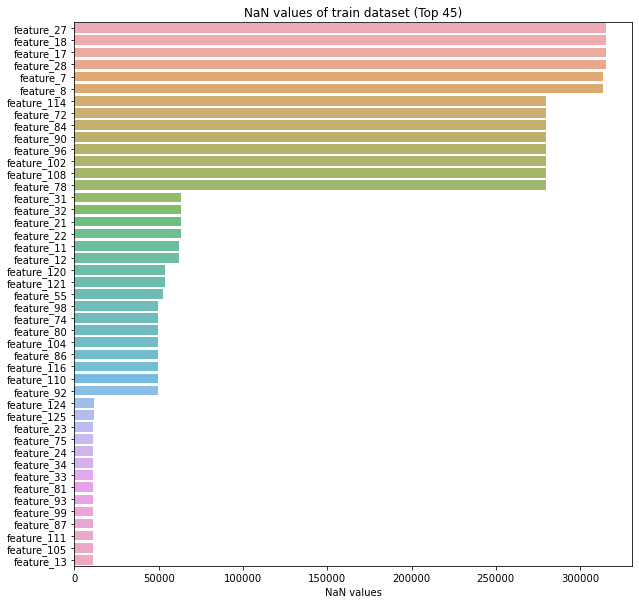

In [6]:
#Checking Missing Values in the features
n_features = 45
nan_val = train.isna().sum()[train.isna().sum() > 0].sort_values(ascending=False)
print(nan_val)


fig, axs = plt.subplots(figsize=(10, 10))

sns.barplot(y = nan_val.index[0:n_features], 
            x = nan_val.values[0:n_features], 
            alpha = 0.8
           )

plt.title(f'NaN values of train dataset (Top {n_features})')
plt.xlabel('NaN values')
fig.savefig(f'nan_values_top_{n_features}_features.png')
plt.show()

In [7]:
#Filling the missing values with median value 
f_median = train.median()
x_train = train.fillna(f_median)

# Creating Train and Test DataFrame 

In [8]:
# Generating 0 or 1 values on the basis of resp features and storing it to 'action' column
# It will serve as our test data 
train['action'] = (train['resp'] > 0 ).astype('int')

In [9]:
X = train.loc[:, train.columns.str.contains('feature')]
y = train.loc[:, 'action']

# Splitting X,y into train and validation data 
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state = 42)

In [10]:
# We can use this to fill nan values in unseen test but here I am not using this
test_median = X.median()

# Exploratory Data Analysis 📈

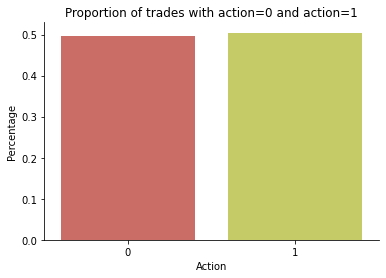

In [11]:
# We will check if the target class is balanced or unbalanced in the training data
sns.set_palette("hls")
ax = sns.barplot(y_train.value_counts().index, y_train.value_counts()/len(y_train))
ax.set_title("Proportion of trades with action=0 and action=1")
ax.set_ylabel("Percentage")
ax.set_xlabel("Action")
sns.despine();

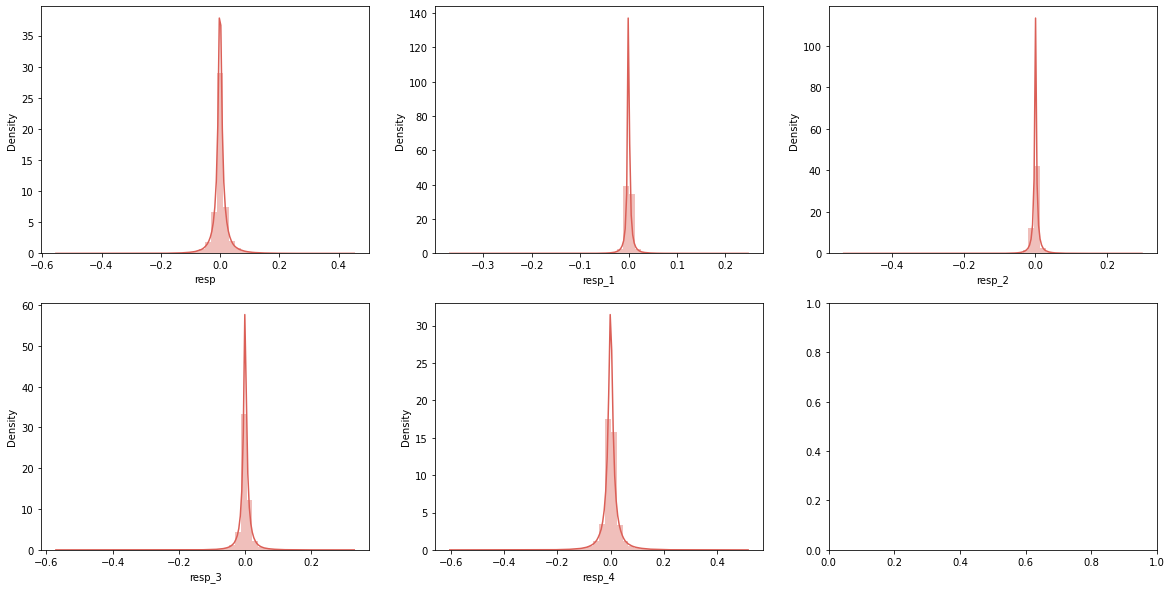

In [12]:
#Resp Analysis
#Last subplot doesn't mean anything
resp_df = ['resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4']
fig, axes = plt.subplots(nrows=2
                         , ncols=3,figsize=(20,10))
for i, column in enumerate(resp_df):
    sns.distplot(train[column],ax=axes[i//3,i%3])

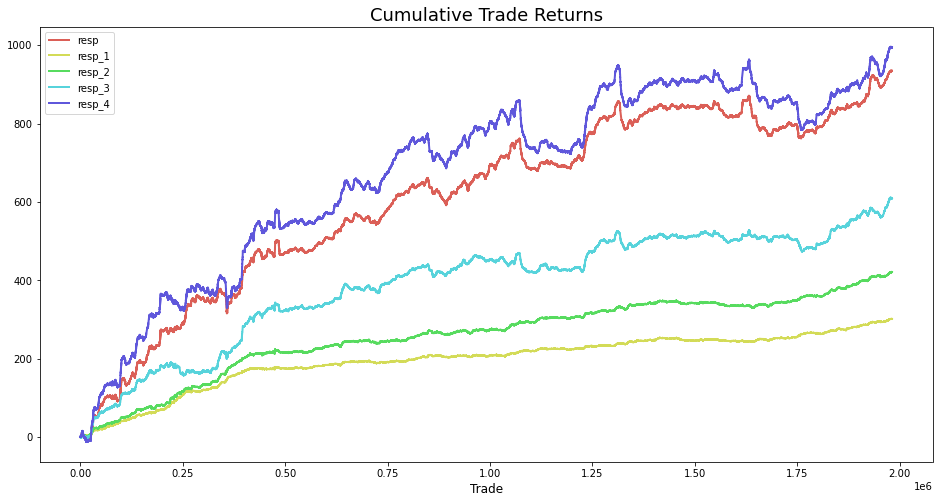

In [13]:
# Cumulative return analysis
fig, ax = plt.subplots(figsize=(16, 8))

resp = train['resp'].cumsum()
resp_1 = train['resp_1'].cumsum()
resp_2 = train['resp_2'].cumsum()
resp_3 = train['resp_3'].cumsum()
resp_4 = train['resp_4'].cumsum()

resp.plot(linewidth=2)
resp_1.plot(linewidth=2)
resp_2.plot(linewidth=2)
resp_3.plot(linewidth=2)
resp_4.plot(linewidth=2)

ax.set_xlabel ("Trade", fontsize=12)
ax.set_title ("Cumulative Trade Returns", fontsize=18)

plt.legend(loc="upper left");

# Visualizations

In [14]:
import warnings
import os, gc, io, requests, math, time
import numpy as np
import pandas as pd
import tensorflow as tf
import dask.dataframe as dd
import matplotlib.pyplot as plt     
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from sklearn.impute import SimpleImputer
from IPython.display import clear_output , Markdown

from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import TruncatedSVD
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

!pip install pmdarima
!pip install ivis
from ivis import Ivis
from pmdarima.preprocessing import BoxCoxEndogTransformer

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from tqdm.notebook import tqdm

%matplotlib inline
warnings.filterwarnings("ignore")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [20, 5]  # width, height
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

clear_output()

ERROR: Could not find a version that satisfies the requirement pmdarima
ERROR: No matching distribution found for pmdarima
ERROR: Could not find a version that satisfies the requirement ivis
ERROR: No matching distribution found for ivis


ModuleNotFoundError: No module named 'ivis'

In [15]:
%%time
traindf = dd.read_csv('/kaggle/input/jane-street-market-prediction/train.csv' ).compute().sort_values('ts_id')
features = [c for c in traindf.columns if "feature" in c]
non_features = [c for c in traindf.columns if "feature" not in c]

traindf['weight_x_resp'] = traindf['weight'] * traindf['resp']
traindf['resp_mean'] = (traindf['resp_1']+traindf['resp_2']+traindf['resp_3']+traindf['resp_4'])/4

#Getting Target Variables
traindf['resp_target'] = (traindf['resp'] > 0).astype(np.int8)
traindf['resp_mean_target'] = (traindf['resp_mean'] > 0).astype(np.int8)

CPU times: user 1min 51s, sys: 19.1 s, total: 2min 10s
Wall time: 1min 42s


In [16]:
%%time
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
traindf = reduce_mem_usage(traindf)


Memory usage of dataframe is 2576.12 MB
Memory usage after optimization is: 670.25 MB
Decreased by 74.0%
CPU times: user 23.3 s, sys: 29.3 s, total: 52.6 s
Wall time: 52.7 s


In [17]:
Markdown('<li>As JointPoint Suggest there is no Statistical Relation Between Resp and Weight.\
          <li>Also Resp Column is <b>Pre-Standardized with Mean : {} and STD : {}</b>.\
          <li>The Data is Lighly Skewed with Skewness : {} \
          <li>Kurtosis Of Series Show its a Leptokurtic Distribution(Kurtosis > 3) With Kurtosis : {}\n'\
         .format(traindf['resp'].mean() , traindf['resp'].std() , scipy.stats.skew(traindf['resp'].values) ,  scipy.stats.kurtosis(traindf['resp'].values)))

<li>As JointPoint Suggest there is no Statistical Relation Between Resp and Weight.          <li>Also Resp Column is <b>Pre-Standardized with Mean : 0.0004074573516845703 and STD : 0.026947021484375</b>.          <li>The Data is Lighly Skewed with Skewness : 0.1036376953125           <li>Kurtosis Of Series Show its a Leptokurtic Distribution(Kurtosis > 3) With Kurtosis : 17.369629144859193


In [18]:
%%time
def get_stats(series , i , outlier_limit = 1.5 ) :
    describe = {}
    time_describe = {}
    describe['Column'] = i
    s_time = time.time()
    start_time = s_time
    
    describe['Mean'] = series.mean();time_describe['Mean'] = time.time() - start_time;start_time = time.time() #Mean of Series    
    describe['Median'] = series.median();time_describe['Median'] = time.time() - start_time;start_time = time.time() #Median of Series
    describe['STD'] = series.std();time_describe['STD'] = time.time() - start_time;start_time = time.time() #Standard Deviation of Series
    describe['Minimum'] = series.min();time_describe['Minimum'] = time.time() - start_time;start_time = time.time() #Minimum of Series
    describe['Maximum'] = series.max();time_describe['Maximum'] = time.time() - start_time;start_time = time.time() #Maximum of Series
    
    
    describe['Q1'] , describe['Q3'] = series.quantile([0.25 , 0.75]) # Quantile 1 and 3 of Series   
    describe['InterQuantile'] = describe['Q3'] - describe['Q1'] # Interquantile Range
    # Calculating Number of Outliers Take lot of time
#     lower_bound = describe['Q1'] - (outlier_limit * describe['InterQuantile']) 
#     upper_bound = describe['Q3'] + (outlier_limit * describe['InterQuantile'])
#     describe['Number of Outliers'] = len([x for x in series.values if x <= lower_bound or x >= upper_bound]) #Number of Outliers
    time_describe['Quantiles'] = time.time() - start_time;start_time = time.time()
    
    describe['Nulls'] = series.isnull().sum();time_describe['Nulls'] = time.time() - start_time;start_time = time.time() #Number of Null Values
    describe['Skewness'] = scipy.stats.skew(series.values);time_describe['Skewness'] = time.time() - start_time;start_time = time.time() # Skewness of Series
    describe['Kurtosis'] = scipy.stats.kurtosis(series.values);time_describe['Kurtosis'] = time.time() - start_time;start_time = time.time() #Kurtosis (Peakness in Distributed Data)
    describe['Variation'] = scipy.stats.skew(series.values);time_describe['Variation'] = time.time() - start_time;start_time = time.time() #Ratio of the biased standard deviation to the mean.
    describe['Entroy'] = scipy.stats.entropy(series.values);time_describe['Entroy'] = time.time() - start_time;start_time = time.time() #Entropy of Series
    
    describe['Total_Time'] = time.time() - s_time
    return [describe , time_describe]

def Custom_Describe(data , columns , sample = 100000):
    r_data = []
    t_data = []
    sample_data = data.sample(sample)
    for i in tqdm(columns):
        return_data = get_stats(sample_data[i] , i)
        r_data.append(return_data[0])
        t_data.append(return_data[1])
    r_data = pd.DataFrame(r_data)
    t_data = pd.DataFrame(t_data)
    return r_data , t_data

r_data  , t_data = Custom_Describe(traindf , non_features[1:-1]+features + ['resp_mean','weight_x_resp'] )
r_data.index = r_data.Column
r_data.drop(columns = ['Column'] , inplace = True)
r_data.to_csv('Traindf_Details.csv')
display(r_data.head(10))


NameError: name 'tqdm' is not defined

In [19]:
r_data.loc[[x  for x in r_data.index.values if 'resp' in x]][['InterQuantile' , 'Skewness' , 'Kurtosis' , 'Variation' , 'Mean' , 'STD']].sort_values(['InterQuantile'])

NameError: name 'r_data' is not defined

In [20]:
print('Percentage of Weight is equal to 0 is ',traindf[traindf['weight'] == 0.0].shape[0]*100/traindf.shape[0])

Percentage of Weight is equal to 0 is  17.117989567833554


CPU times: user 7.88 s, sys: 109 ms, total: 7.99 s
Wall time: 8.35 s


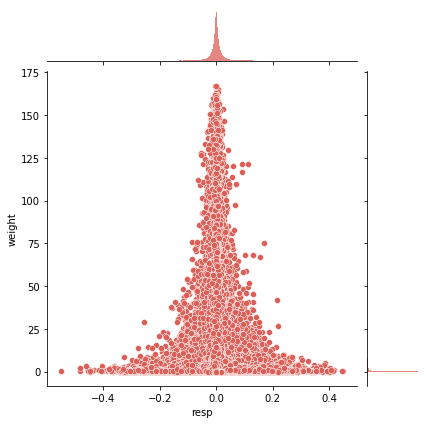

In [21]:
%%time
sns.jointplot(x = 'resp' ,y= 'weight' , data = traindf , kind = 'scatter')

<AxesSubplot:xlabel='weight', ylabel='Density'>

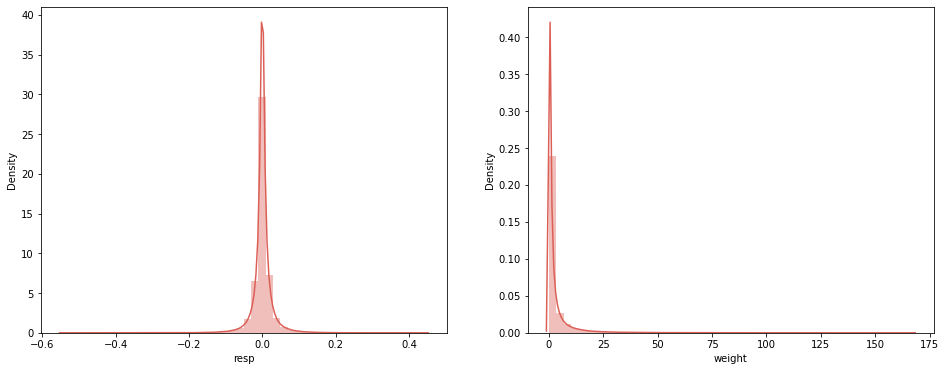

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.distplot(traindf['resp'], ax=axs[0])
sns.distplot(traindf['weight'], ax=axs[1])

<AxesSubplot:>

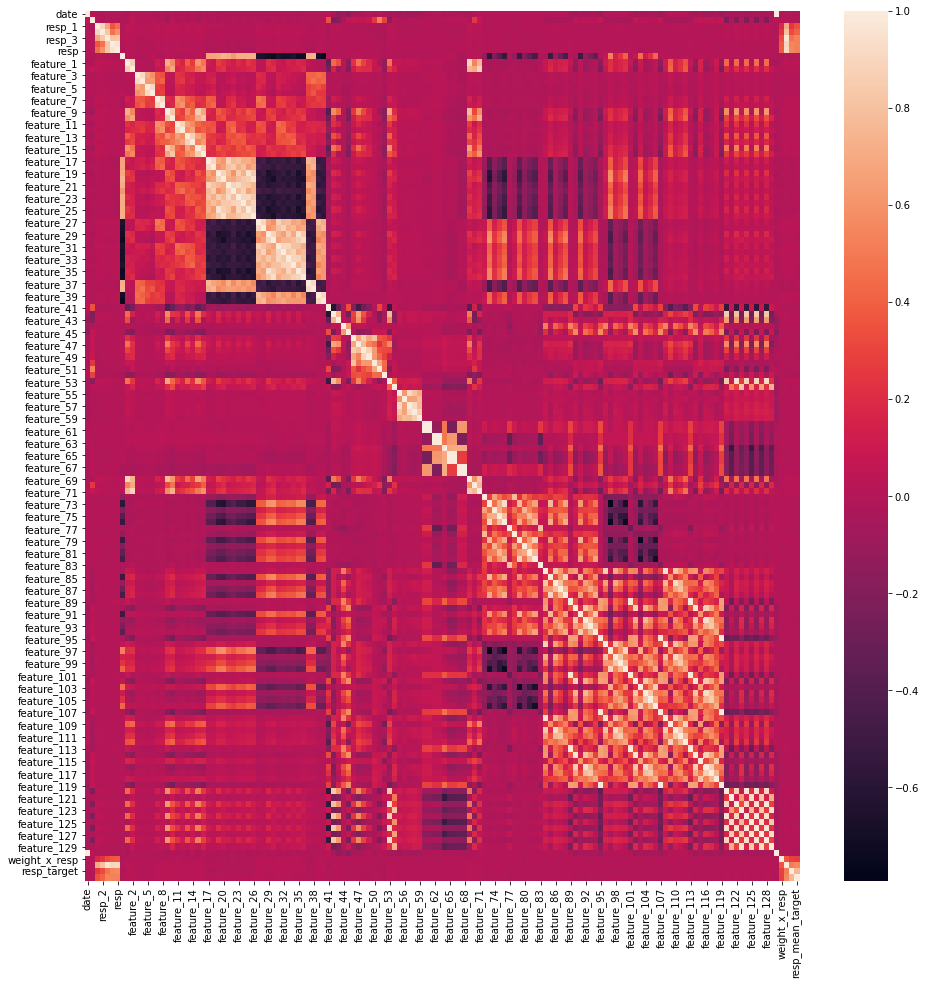

In [23]:
correlations = traindf.sample(100000).corr(method='pearson')
fig, axs = plt.subplots(figsize=(16, 16))
sns.heatmap(correlations)

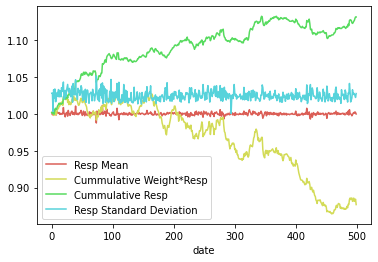

In [24]:
(1+traindf.groupby('date')['resp'].mean()).plot(label = 'Resp Mean')
(1+traindf.groupby('date')['weight_x_resp'].mean()).cumprod().plot(label = 'Cummulative Weight*Resp')
(1+traindf.groupby('date')['resp'].mean()).cumprod().plot(label = 'Cummulative Resp')
(1+traindf.groupby('date')['resp'].std()).plot(label = 'Resp Standard Deviation')
plt.legend()

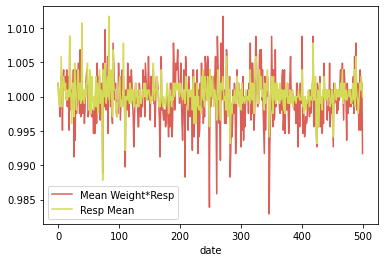

In [25]:
(1+traindf.groupby('date')['weight_x_resp'].mean()).plot(label = 'Mean Weight*Resp')
(1+traindf.groupby('date')['resp'].mean()).plot(label = 'Resp Mean')
plt.legend()

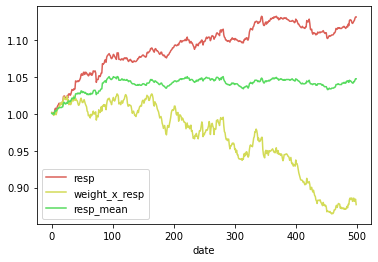

In [26]:
(1+traindf.groupby('date')['resp'].mean()).cumprod().plot()
(1+traindf.groupby('date')['weight_x_resp'].mean()).cumprod().plot()
(1+traindf.groupby('date')['resp_mean'].mean()).cumprod().plot()
plt.legend()

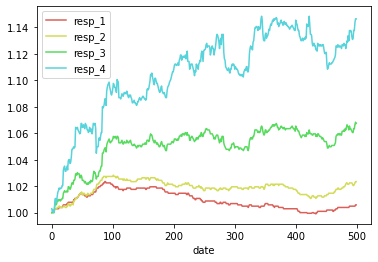

In [27]:
(1+traindf.groupby('date')['resp_1'].mean()).cumprod().plot()
(1+traindf.groupby('date')['resp_2'].mean()).cumprod().plot()
(1+traindf.groupby('date')['resp_3'].mean()).cumprod().plot()
(1+traindf.groupby('date')['resp_4'].mean()).cumprod().plot()
plt.legend()

[]

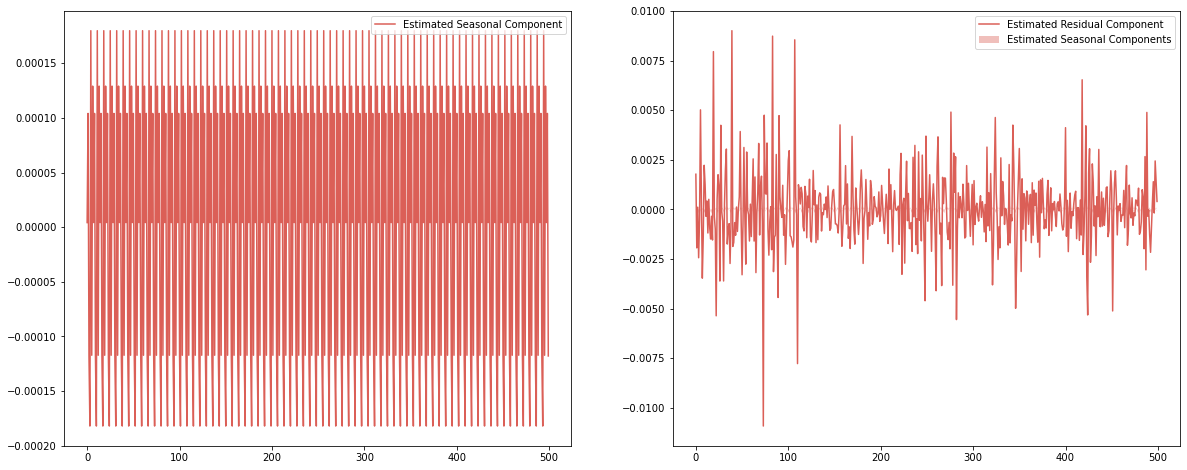

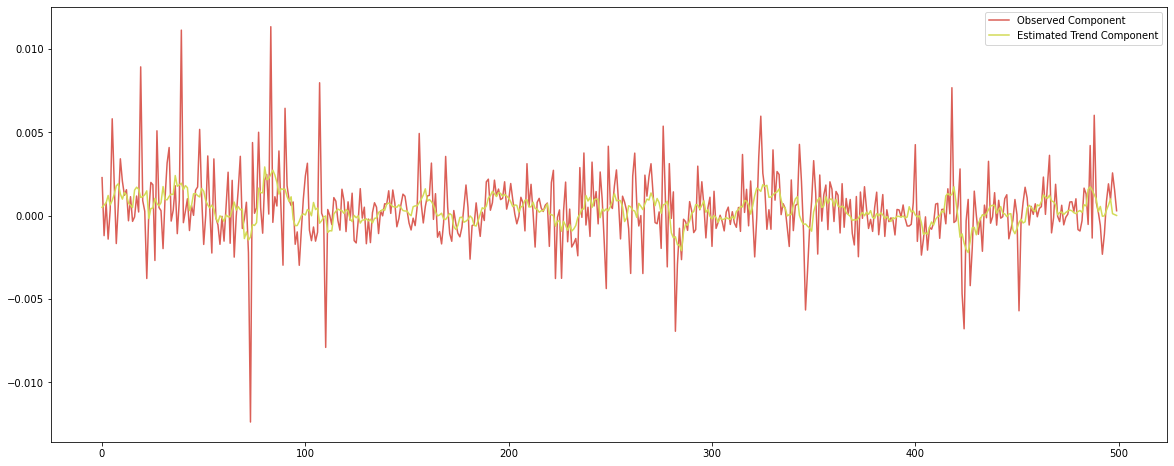

In [28]:
Season_Period = 7
Model_Behaviour = "add"

data = traindf.groupby('date')['resp'].mean()

if Model_Behaviour == 'mul':
    data = data + 1
seas_d=sm.tsa.seasonal_decompose(data ,model=Model_Behaviour,period=Season_Period , extrapolate_trend='freq')
clear_output()

Plt_Col = 2
Plt_Row = 1
plt.figure(figsize=(20,16/Plt_Col))

plt.subplot(Plt_Row,Plt_Col , 1)
plt.plot(seas_d.seasonal.values , label = 'Estimated Seasonal Component')
# plt.fill_between(list(range(seas_d.nobs[0])) ,0, seas_d.seasonal.values , alpha =0.4)
plt.legend()

plt.subplot(Plt_Row,Plt_Col , 2)
plt.plot(seas_d.resid.values , label = 'Estimated Residual Component')
plt.fill_between(list(range(seas_d.nobs[0])) ,0, seas_d.seasonal.values , alpha =0.4 , label = 'Estimated Seasonal Components')
plt.legend()

plt.plot()

plt.figure(figsize=(20,16/Plt_Col))
plt.plot(seas_d.observed.values , label = 'Observed Component')
plt.plot(seas_d.trend.values , label = 'Estimated Trend Component')
plt.legend()
plt.plot()

In [29]:
data = 1 + traindf.groupby('date')['weight'].mean()
Plt_Col = 4
freq = []

freq.append([data.values.reshape(-1)  , 'Original Data'])
freq.append([data.diff().values.reshape(-1)  , 'Difference of Original Data'])
# freq.append([data.cumprod().values.reshape(-1)  , 'Cummulative Product Plot'])
freq.append([data.cumsum().values.reshape(-1)  , 'Cummulative Sum Plot'])
freq.append([np.log1p(data).values.reshape(-1) , 'Log1p Fuction'])
freq.append([np.sqrt(data).values.reshape(-1) , 'Square Root Function'])
freq.append([np.cbrt(data).values.reshape(-1) , 'Cube Root Function'])
freq.append([np.sqrt(np.sqrt(data)).values.reshape(-1) , 'Quad Root Function'])
freq.append([np.square(data).values.reshape(-1) , 'Square Function'])
freq.append([preprocessing.MinMaxScaler().fit_transform(data.values.reshape(-1,1)).reshape(-1) , 'Min Max Scaler Function'])
freq.append([preprocessing.RobustScaler().fit_transform(data.values.reshape(-1,1)).reshape(-1) , 'Robust Scaler Function'])
freq.append([preprocessing.StandardScaler().fit_transform(data.values.reshape(-1,1)).reshape(-1) , 'Standard Scaler Function'])
freq.append([preprocessing.PowerTransformer().fit_transform(data.values.reshape(-1,1)).reshape(-1) , 'Power Transformer Scaler'])
freq.append([sm.tsa.filters.bkfilter(data).values.reshape(-1) , 'BKFilter Band Pass Filter'])
freq.append([sm.tsa.filters.hpfilter(data)[1].values.reshape(-1) , 'HPFilter Smoothing Filter'])
freq.append([sm.tsa.filters.hpfilter(data.cumprod())[1].values.reshape(-1) , 'HPFilter  on CumPord'])
freq.append([BoxCoxEndogTransformer().fit_transform(data+0.00000001)[0], 'BoxCoxEndogTransformer Filter'])

Plt_Row = math.ceil(len(freq)/Plt_Col)
plt.figure(figsize=(16,12*Plt_Row/Plt_Col))

for i,j in enumerate(freq):
    plt.subplot(Plt_Row , Plt_Col , i+1)
    plt.plot(j[0], label = j[1] , linewidth = .8)
  
    plt.legend(loc = 2)

NameError: name 'BoxCoxEndogTransformer' is not defined

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [30]:
data = 1 + traindf.groupby('date')['weight'].mean()
Plt_Col = 4
freq = []

freq.append([data.values.reshape(-1)  , 'Original Data'])
freq.append([data.diff().values.reshape(-1)  , 'Difference of Original Data'])
# freq.append([data.cumprod().values.reshape(-1)  , 'Cummulative Product Plot'])
freq.append([data.cumsum().values.reshape(-1)  , 'Cummulative Sum Plot'])
freq.append([np.log1p(data).values.reshape(-1) , 'Log1p Fuction'])
freq.append([np.sqrt(data).values.reshape(-1) , 'Square Root Function'])
freq.append([np.cbrt(data).values.reshape(-1) , 'Cube Root Function'])
freq.append([np.sqrt(np.sqrt(data)).values.reshape(-1) , 'Quad Root Function'])
freq.append([np.square(data).values.reshape(-1) , 'Square Function'])
freq.append([preprocessing.MinMaxScaler().fit_transform(data.values.reshape(-1,1)).reshape(-1) , 'Min Max Scaler Function'])
freq.append([preprocessing.RobustScaler().fit_transform(data.values.reshape(-1,1)).reshape(-1) , 'Robust Scaler Function'])
freq.append([preprocessing.StandardScaler().fit_transform(data.values.reshape(-1,1)).reshape(-1) , 'Standard Scaler Function'])
freq.append([preprocessing.PowerTransformer().fit_transform(data.values.reshape(-1,1)).reshape(-1) , 'Power Transformer Scaler'])
freq.append([sm.tsa.filters.bkfilter(data).values.reshape(-1) , 'BKFilter Band Pass Filter'])
freq.append([sm.tsa.filters.hpfilter(data)[1].values.reshape(-1) , 'HPFilter Smoothing Filter'])
freq.append([sm.tsa.filters.hpfilter(data.cumprod())[1].values.reshape(-1) , 'HPFilter  on CumPord'])
freq.append([BoxCoxEndogTransformer().fit_transform(data+0.00000001)[0], 'BoxCoxEndogTransformer Filter'])

Plt_Row = math.ceil(len(freq)/Plt_Col)
plt.figure(figsize=(16,12*Plt_Row/Plt_Col))

for i,j in enumerate(freq):
    plt.subplot(Plt_Row , Plt_Col , i+1)
    plt.plot(j[0], label = j[1] , linewidth = .8)
  
    plt.legend(loc = 2)

NameError: name 'BoxCoxEndogTransformer' is not defined

# Training XGBClassifier | Using Optuna for Hyperparameter Tuning

In [31]:
# Created the Xgboost specific DMatrix data format from the numpy array to optimise memory consumption
dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_valid, label=y_valid)

In [32]:
def objective(trial):
    
# params specifies the XGBoost hyperparameters to be tuned
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 600),
        'max_depth': trial.suggest_int('max_depth', 10, 20),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, .1),
        'subsample': trial.suggest_uniform('subsample', 0.50, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 1),
        'gamma': trial.suggest_int('gamma', 0, 10),
        'tree_method': 'gpu_hist',  
        'objective': 'binary:logistic'
    }
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
# trials will be evaluated based on their accuracy on the test set
    accuracy = sklearn.metrics.accuracy_score(y_valid, pred_labels)
    return accuracy

In [33]:
study = optuna.create_study()
study.optimize(objective,n_trials=5) 
#You can increase n_trials parameter

[I 2021-02-07 16:33:52,069] A new study created in memory with name: no-name-9be809ba-c3fc-45cb-b160-2fc02f43b966


[16:33:52] WARNING: ../src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:33:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-02-07 16:33:58,696] Trial 0 finished with value: 0.5578739104320922 and parameters: {'n_estimators': 419, 'max_depth': 16, 'learning_rate': 0.05114192958757659, 'subsample': 0.6269963974489488, 'colsample_bytree': 0.5062421061494637, 'gamma': 8}. Best is trial 0 with value: 0.5578739104320922.


[16:33:58] WARNING: ../src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:33:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-02-07 16:34:02,614] Trial 1 finished with value: 0.5523926330824867 and parameters: {'n_estimators': 435, 'max_depth': 14, 'learning_rate': 0.01629830604364764, 'subsample': 0.7197067095753207, 'colsample_bytree': 0.5109505966332071, 'gamma': 6}. Best is trial 1 with value: 0.5523926330824867.


[16:34:02] WARNING: ../src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:34:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-02-07 16:34:10,999] Trial 2 finished with value: 0.5583130182860662 and parameters: {'n_estimators': 439, 'max_depth': 16, 'learning_rate': 0.08174281219331891, 'subsample': 0.593611224221021, 'colsample_bytree': 0.5741274843242643, 'gamma': 2}. Best is trial 1 with value: 0.5523926330824867.


[16:34:11] WARNING: ../src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:34:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-02-07 16:34:14,396] Trial 3 finished with value: 0.5507699529094681 and parameters: {'n_estimators': 577, 'max_depth': 13, 'learning_rate': 0.07053405790173047, 'subsample': 0.5928287849074685, 'colsample_bytree': 0.6468093917694464, 'gamma': 2}. Best is trial 3 with value: 0.5507699529094681.


[16:34:14] WARNING: ../src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:34:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-02-07 16:34:23,005] Trial 4 finished with value: 0.5597565222657965 and parameters: {'n_estimators': 547, 'max_depth': 16, 'learning_rate': 0.09569936552573652, 'subsample': 0.6054170757508555, 'colsample_bytree': 0.6194802136452706, 'gamma': 0}. Best is trial 3 with value: 0.5507699529094681.


In [34]:
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.5507699529094681, params {'n_estimators': 577, 'max_depth': 13, 'learning_rate': 0.07053405790173047, 'subsample': 0.5928287849074685, 'colsample_bytree': 0.6468093917694464, 'gamma': 2}


In [35]:
best_params = study.best_trial.params
best_params['tree_method'] = 'gpu_hist'      #gpu_hist is really fast
best_params['objective'] = 'binary:logistic'

In [36]:
del x_train, x_valid, y_train, y_valid, dtrain, dvalid  #free some space

In [37]:
# Fit the XGBoost classifier with optimal hyperparameters
clf = xgb.XGBClassifier(**best_params)

In [38]:
%time clf.fit(X, y)  #Used the whole training data

[16:34:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 2min 57s, sys: 2 s, total: 2min 59s
Wall time: 2min 58s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6468093917694464, gamma=2,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.07053405790173047, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=577, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.5928287849074685, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

# Fitting classifier on test data

In [39]:
from tqdm import tqdm
import janestreet
env = janestreet.make_env() # initialize the environment
iter_test = env.iter_test() # an iterator which loops over the test set

In [40]:
for (test_df, pred_df) in tqdm(iter_test):
    if test_df['weight'].item() > 0:
        X_test = test_df.loc[:, test_df.columns.str.contains('feature')]
        y_preds = clf.predict(X_test)
        pred_df.action = y_preds
    else:
        pred_df.action = 0
    env.predict(pred_df)

15219it [03:37, 69.90it/s] 
